In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Предопределенные константы

In [3]:
lightSpeed = 3e10

In [4]:
R = 0.35
T_w = 2000
T_0 = 1e4
k_0 = 8e-4
p = 15

F_CONST = 0.393

In [5]:
NUMBER_OF_STEPS = 100
HALF_DIVISION_STEP_LIMIT = 100

### Базовые функции

In [6]:
def Tz(z: float):
    return (T_w - T_0)*z**p + T_0

def Kz(z: float):
    return k_0 * (Tz(z) / 300)**2

def Up(z: float):
    return 3.084e-4 / (np.exp(4.799e4 / Tz(z)) -1)

In [7]:
def dU_dz(z: float, f: float):
    return -(3 * R * f * Kz(z)) / lightSpeed

def dF_dz(z, f, u):
    if abs(z - 0) < 1e-4:
        return 0.5 * R * lightSpeed * Kz(z) * (Up(z) - u)
    
    return R * lightSpeed * Kz(z) * (Up(z) - u) - (f / z)

In [8]:
def RungeCutt4(f0: float, u0: float, z0: float, z_max: float):
    zs = np.linspace(z0, z_max, NUMBER_OF_STEPS+1)
    zp = z0
    
    f_res = np.zeros(zs.shape)
    f_res[0] = f0
    u_res = np.zeros(zs.shape)
    u_res[0] = u0

    for i, zi in enumerate(zs[1:]):
        h = zi - zp

        f_n = f_res[i]
        u_n = u_res[i]

        k1 = h * dU_dz(zi, f_n)
        g1 = h * dF_dz(zi, f_n, u_n)

        k2 = h * dU_dz(zi + 0.5 * h, f_n + 0.5 * g1)
        g2 = h * dF_dz(zi + 0.5 * h, f_n + 0.5 * g1, u_n + 0.5 * k1)

        k3 = h * dU_dz(zi + 0.5 * h, f_n + 0.5 * g2)
        g3 = h * dF_dz(zi + 0.5 * h, f_n + 0.5 * g2, u_n + 0.5 * k2)

        k4 = h * dU_dz(zi + h, f_n + g3)
        g4 = h * dF_dz(zi + h, f_n + g3, u_n + k3)

        f_res[i + 1] = f_n + (g1 + 2 * g2 + 2 * g3 + g4) / 6
        u_res[i + 1] = u_n + (k1 + 2 * k2 + 2 * k3 + k4) / 6

        zp = zi

    return zs, f_res, u_res


In [9]:
def get_Δ(f, u):
    return f - F_CONST * lightSpeed * u / 2

def get_last_Δ(_, fs, us):
    return get_Δ(fs[-1], us[-1])

def find_ξ():
    ξs = np.linspace(1e-2, 1, NUMBER_OF_STEPS + 1)

    ξa = ξb = ξs[0]

    up0 = Up(0)
    for ξ in ξs:
        Δ = get_last_Δ(*RungeCutt4(0, ξ * up0, 0, 1))
        
        if Δ < 0:
            ξb = ξ
            break
        else:
            ξa = ξ

    return ξa, ξb


### Метод половинного деления

In [10]:
def halfDivision():
    ε = 1e-4

    ξa, ξb = find_ξ()
    ξ = (ξa + ξb) / 2

    up0 = Up(0)
    step = 0
    while (abs((ξa - ξb) / ξ) > ε) and step < HALF_DIVISION_STEP_LIMIT:
        ξ = (ξa + ξb) / 2

        Δa = get_last_Δ(*RungeCutt4(0, ξa * up0, 0, 1))
        Δ = get_last_Δ(*RungeCutt4(0, ξ * up0, 0, 1))

        if Δa * Δ >= 0:
            ξa = ξ
        else:
            ξb = ξ

        step += 1

    return ξ


### Отрисовка

In [11]:
ξ = halfDivision()
z_res, f_res, u_res = RungeCutt4(0, ξ * Up(0), 0,  1)
Δs = get_Δ(f_res, u_res)

t_res = Tz(z_res)
up_res = Up(z_res)

Text(0.5, 1.0, 'U(z)')

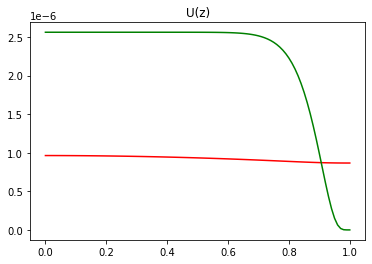

In [12]:
plt.plot(z_res, u_res, 'r')
plt.plot(z_res, up_res, 'g')
plt.title('U(z)')

Text(0.5, 1.0, 'F(z)')

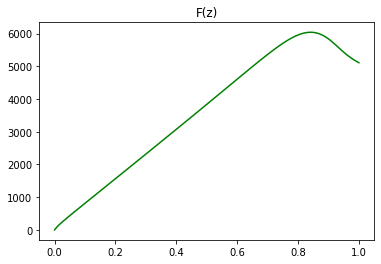

In [13]:

plt.plot(z_res, f_res, 'g')
plt.title('F(z)')

Text(0.5, 1.0, 'ξ = 0.376203')

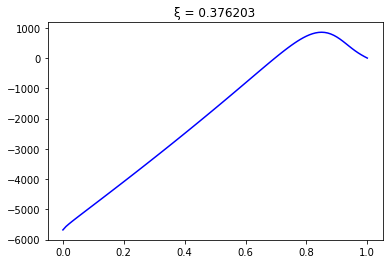

In [14]:
plt.plot(z_res, Δs, 'b')
plt.title(f"ξ = {ξ:.6f}")


Text(0.5, 1.0, 'T(z)')

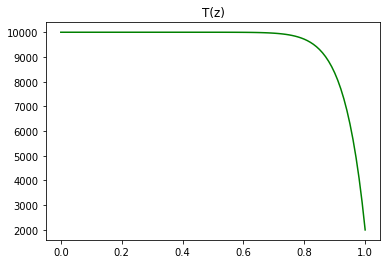

In [15]:
plt.plot(z_res, t_res, 'g')
plt.title("T(z)")